# 3D projection

By using the camera ground truth position we can backprocject the events with the estimated depth to a 3D point and see how the result is. (**This does not work currently**)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
network_out = np.load("result_3-3.npy")

In [3]:
pos = np.loadtxt("../../tum-vie/gt_data_range.txt")

In [4]:
n_steps = 50
duration = 0.1
time_step = duration / n_steps

In [5]:
pos_x = pos[:,1]
pos_y = pos[:,2]
pos_z = pos[:,3]
pos_t = pos[:,0] - pos[0,0]
rot_quat = pos[:,4:]

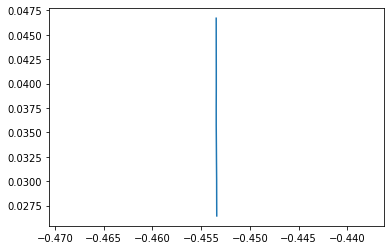

In [6]:
plt.axis("equal")
plt.plot(pos_x, pos_y)

In [7]:
fx = 1049.048422241493
fy = 1049.5741104057763
cx = 652.4780618014456
cy = 262.0071641027953
k1 = -0.12160659649371726
k2 = 0.011651206770983776
k3 = -0.04866892385445637
k4 = 0.039710386685279195

In [8]:
K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
]).astype(float)
D = np.array([k1, k2, k3, k4]).astype(float)

In [9]:
import cv2 as cv

In [10]:
points = np.array([(0, 0)])
points = np.float32(points[:, np.newaxis, :])
u = cv.fisheye.undistortPoints(points, K, D)
np.append(u[0,0], 1.0)

array([-0.80614585, -0.32355142,  1.        ])

In [11]:
from scipy.spatial.transform import Rotation as R

In [12]:
r_init = R.from_quat(pos[0,4:])

In [13]:
type(r_init.as_matrix())

numpy.ndarray

In [14]:
from scipy.spatial.transform import Slerp
slerp = Slerp(pos_t, R.from_quat(rot_quat))

In [15]:
from tqdm import tqdm
results = []
for t in tqdm(range(network_out.shape[2])):
    for y in range(network_out.shape[0]):
        for x in range(network_out.shape[1]):
            if network_out[y, x, t] == 0:
                continue
            time = t * time_step
            #rectify px
#             point = np.array([(x, y)])
#             point = np.float32(point[:, np.newaxis, :])
#             u = cv.fisheye.undistortPoints(points, K, D)[0,0]
#             u = np.append(u, 1.0)
            u = np.array([x, y, 1.0])
            #compute r
            r = slerp(time).as_matrix()
            r = r_init.as_matrix()
            #compute t
            cam_x = np.interp(time, pos_t, pos_x)
            cam_y = np.interp(time, pos_t, pos_y)
            cam_z = np.interp(time, pos_t, pos_z)
            cam_x = pos_x[0]
            cam_y = pos_y[0]
            cam_z = pos_z[0]
            t_cam = np.array([cam_y, cam_x, cam_y])
            #compute c and d
            c = - r.transpose() @ t_cam
            d = r.transpose() @ u
            X = network_out[y, x, t]*d + c
            #X = d + c
            results.append(X)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.18it/s]


In [16]:
result = np.array(results)
#result[:,2] = 20

In [17]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(result[:,0], result[:,1], result[:,2], s=0.1)
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

#set_axes_equal(ax)
plt.show()

In [18]:
result.shape

(8025, 3)

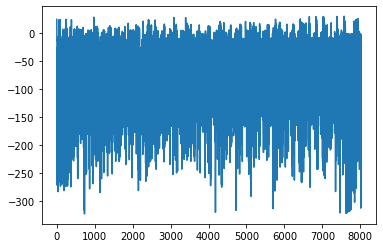

In [19]:
%matplotlib inline
plt.clf()
plt.plot(result[:,2])

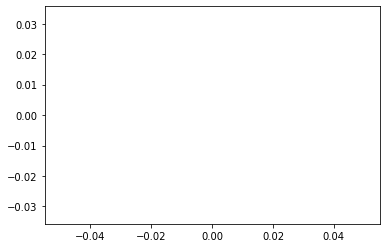

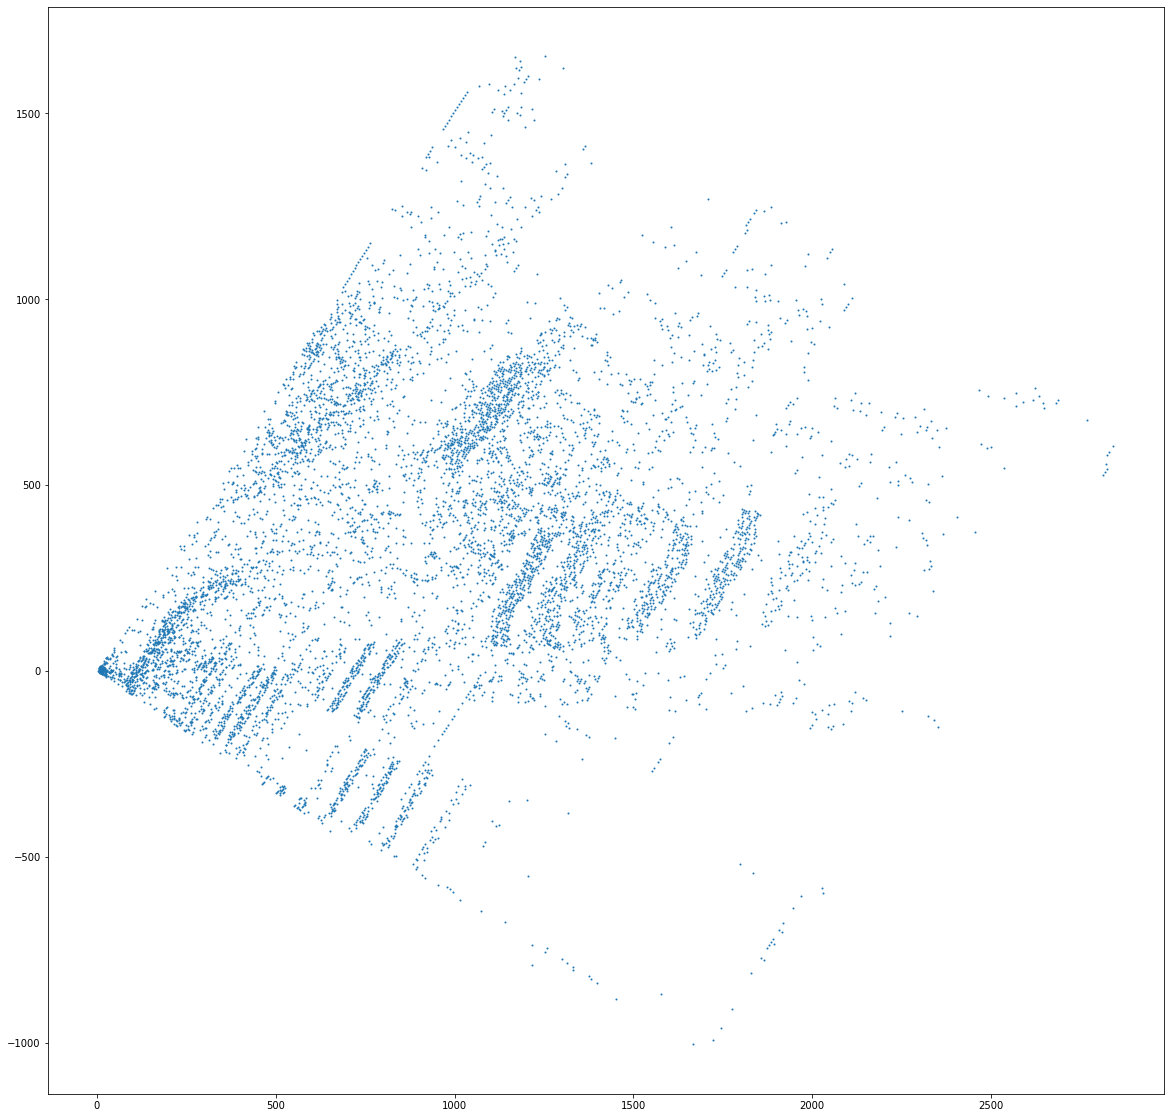

In [20]:
plt.axis("equal")
plt.figure(figsize=(20, 20))
plt.scatter(result[:,0], result[:,1], s=1)

In [21]:
from scipy.linalg import null_space

In [22]:
from tqdm import tqdm
results = []
for t in tqdm(range(network_out.shape[2])):
    for y in range(network_out.shape[0]):
        for x in range(network_out.shape[1]):
            if network_out[y, x, t] == 0:
                continue
            time = t * time_step
            #rectify px
#             point = np.array([(x, y)])
#             point = np.float32(point[:, np.newaxis, :])
#             u = cv.fisheye.undistortPoints(points, K, D)[0,0]
#             u = np.append(u, 1.0)
            u = np.array([x, y, 1.0])
            #compute r
            r = slerp(time).as_matrix()
            r = r_init.as_matrix()
            #compute t
            cam_x = np.interp(time, pos_t, pos_x)
            cam_y = np.interp(time, pos_t, pos_y)
            cam_z = np.interp(time, pos_t, pos_z)
            t_cam = np.array([cam_x, cam_y, cam_y])
            # P
            p = np.hstack((r, t_cam.reshape(3,1)))
#             c = - np.linalg.inv(r) @ t_cam
#             d = np.linalg.pinv(p) @ u
            X = np.linalg.pinv(r) @ (network_out[y, x, t]*u- t_cam)
            results.append(X)
            
result = np.array(results)
# result[:,2] *= 20

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.72it/s]


In [23]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(result[:,0], result[:,1], result[:,2], s=0.05)
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

#set_axes_equal(ax)
plt.show()

# Simple projection in 3D space

Instead of doing a proper projection, we can simply use the x and y of the event and the estimated depth to plot the results.
As expected the results seem very noisy and for some reasons the events are grouped in planes instead of having a wide range of values. (This is probably due to the fixed decay value)

In [26]:
from tqdm import tqdm
results = []
for t in tqdm(range(network_out.shape[2])):
    for y in range(network_out.shape[0]):
        for x in range(network_out.shape[1]):
            if network_out[y, x, t] == 0:
                continue
            time = t * time_step
            X = np.array([x, y, np.log(network_out[y, x, t])])
            results.append(X)
            
result = np.array(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 52.85it/s]


In [28]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(result[:,0], result[:,1], result[:,2], s=0.05, c=result[:,2])
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

#set_axes_equal(ax)
plt.show()

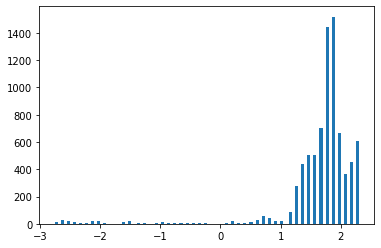

In [30]:
%matplotlib inline
plt.hist(result[:,2].flatten(), 100);